# InternVL3 2D Grounding with OpenRouter API

This notebook demonstrates advanced 2D object grounding using InternVL3 through OpenRouter API instead of downloading the model locally.

Key features:
- **OpenRouter API Integration**: Use InternVL3 models remotely without local storage requirements
- **2D Object Grounding**: Locate objects in images based on natural language descriptions  
- **Coordinate Parsing**: Extract and parse bounding box coordinates from model responses
- **Visualization**: Draw bounding boxes and labels on images
- **Multiple Models**: Support for different InternVL3 model sizes via OpenRouter

See how InternVL3 combines visual and linguistic understanding for precise object localization.


## 🚀 Setup Environment

First, let's install the required dependencies and set up the environment.


In [1]:
# Install required packages
%pip install openai pillow requests numpy

# Set up OpenRouter API key
import os
# Make sure to set your OpenRouter API key
# You can get one from: https://openrouter.ai/keys
if not os.getenv('OPENROUTER_API_KEY'):
    print("⚠️  Warning: OPENROUTER_API_KEY environment variable not set!")
    print("Please set it with: export OPENROUTER_API_KEY='your_api_key_here'")
else:
    print("✅ OpenRouter API key found!")


Note: you may need to restart the kernel to use updated packages.
✅ OpenRouter API key found!


## 📚 Import Libraries and Utilities

Load all required libraries and set up visualization utilities.


In [2]:
import os
import json
import re
import base64
from typing import Dict, List, Optional, Tuple, Union
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import requests
import io
from openai import OpenAI

# Additional colors for visualization
from PIL import ImageColor
additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

# Define standard colors
colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
] + additional_colors

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 🤖 InternVL3 OpenRouter Grounder Class

Core class for 2D object grounding using InternVL3 via OpenRouter API.


In [3]:
class InternVL3OpenRouterGrounder:
    def __init__(
        self, 
        model_id: str = "opengvlab/internvl3-14b",
        api_key: Optional[str] = None,
        base_url: str = "https://openrouter.ai/api/v1"
    ):
        """
        Initialize InternVL3 grounder using OpenRouter API
        
        Args:
            model_id: Model ID available on OpenRouter (e.g., "opengvlab/internvl3-14b")
            api_key: OpenRouter API key (if not provided, will use OPENROUTER_API_KEY env var)
            base_url: OpenRouter API base URL
        """
        self.model_id = model_id
        self.api_key = api_key or os.getenv('OPENROUTER_API_KEY')
        
        if not self.api_key:
            raise ValueError("OpenRouter API key is required. Set OPENROUTER_API_KEY environment variable or pass api_key parameter.")
        
        # Initialize OpenAI client with OpenRouter settings
        self.client = OpenAI(
            api_key=self.api_key,
            base_url=base_url
        )
        
        print(f"✅ InternVL3 Grounder initialized with model: {model_id}")
    
    def encode_image(self, image_path: Union[str, Image.Image]) -> str:
        """Encode image to base64 string"""
        if isinstance(image_path, str):
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode("utf-8")
        else:
            # Handle PIL Image
            buffer = io.BytesIO()
            image_path.save(buffer, format='JPEG')
            return base64.b64encode(buffer.getvalue()).decode("utf-8")
    
    def parse_coordinates(self, response: str) -> Optional[List[float]]:
        """
        Parse bounding box coordinates from model response
        Supports multiple coordinate formats
        """
        # Remove any markdown formatting
        response = response.replace('```', '').replace('json', '').strip()
        
        # Pattern 1: [x1, y1, x2, y2] format
        pattern1 = r'\[(\d+(?:\.\d+)?),\s*(\d+(?:\.\d+)?),\s*(\d+(?:\.\d+)?),\s*(\d+(?:\.\d+)?)\]'
        match1 = re.search(pattern1, response)
        if match1:
            return [float(x) for x in match1.groups()]
        
        # Pattern 2: <x1><y1><x2><y2> format 
        pattern2 = r'<(\d+(?:\.\d+)?)><(\d+(?:\.\d+)?)><(\d+(?:\.\d+)?)><(\d+(?:\.\d+)?)>'
        match2 = re.search(pattern2, response)
        if match2:
            return [float(x) for x in match2.groups()]
            
        # Pattern 3: Simple comma-separated coordinates
        pattern3 = r'(\d+(?:\.\d+)?)\s*,\s*(\d+(?:\.\d+)?)\s*,\s*(\d+(?:\.\d+)?)\s*,\s*(\d+(?:\.\d+)?)'
        match3 = re.search(pattern3, response)
        if match3:
            return [float(x) for x in match3.groups()]
        
        # Pattern 4: Try to extract from JSON response
        try:
            # Look for bbox or coordinates in JSON
            json_match = re.search(r'\{.*\}', response, re.DOTALL)
            if json_match:
                json_data = json.loads(json_match.group())
                if 'bbox' in json_data:
                    return json_data['bbox']
                elif 'coordinates' in json_data:
                    return json_data['coordinates']
        except:
            pass
            
        return None


In [4]:
# Continue the InternVL3OpenRouterGrounder class with grounding methods

def add_grounding_methods():
    """Add the main grounding methods to the InternVL3OpenRouterGrounder class"""
    
    def ground_object(self, image_path: Union[str, Image.Image], referring_expression: str, 
                     system_prompt: str = "You are a helpful assistant specialized in visual object localization.",
                     max_tokens: int = 1024) -> Dict:
        """
        Perform 2D grounding on an image given a referring expression
        
        Args:
            image_path: Path to image file or PIL Image object
            referring_expression: Text description of the object to ground
            system_prompt: System prompt for the model
            max_tokens: Maximum tokens to generate
            
        Returns:
            Dict with 'response', 'coordinates', 'image_size', and 'referring_expression'
        """
        # Get image size
        if isinstance(image_path, str):
            image = Image.open(image_path).convert('RGB')
        else:
            image = image_path.convert('RGB')
        image_size = image.size
        
        # Encode image to base64
        base64_image = self.encode_image(image_path)
        
        # Create grounding prompt - using InternVL3's format
        grounding_prompt = f"Please provide the bounding box coordinates of the region this sentence describes: <ref>{referring_expression}</ref>. Return the coordinates in the format [x1, y1, x2, y2] where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner."
        
        messages = [
            {
                "role": "system", 
                "content": system_prompt
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                    },
                    {
                        "type": "text", 
                        "text": grounding_prompt
                    }
                ]
            }
        ]
        
        try:
            # Call OpenRouter API
            completion = self.client.chat.completions.create(
                model=self.model_id,
                messages=messages,
                max_tokens=max_tokens,
                temperature=0  # Use deterministic output for grounding
            )
            
            response = completion.choices[0].message.content
            
            # Parse coordinates from response
            coordinates = self.parse_coordinates(response)
            
            return {
                'response': response,
                'coordinates': coordinates,
                'image_size': image_size,
                'referring_expression': referring_expression,
                'success': coordinates is not None
            }
            
        except Exception as e:
            print(f"Error during grounding: {e}")
            return {
                'response': str(e),
                'coordinates': None,
                'image_size': image_size,
                'referring_expression': referring_expression,
                'success': False
            }
    
    def visualize_grounding(self, image_path: Union[str, Image.Image], result: Dict, 
                          save_path: Optional[str] = None) -> Image.Image:
        """
        Visualize grounding results by drawing bounding box on image
        
        Args:
            image_path: Path to original image or PIL Image
            result: Result from ground_object method
            save_path: Optional path to save visualization
            
        Returns:
            PIL Image with visualization
        """
        # Load original image
        if isinstance(image_path, str):
            image = Image.open(image_path).convert('RGB')
        else:
            image = image_path.convert('RGB')
            
        # Create a copy for drawing
        vis_image = image.copy()
        draw = ImageDraw.Draw(vis_image)
        
        if result['coordinates']:
            x1, y1, x2, y2 = result['coordinates']
            
            # Draw bounding box
            draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
            
            # Add text label
            text = result['referring_expression']
            if len(text) > 50:
                text = text[:47] + "..."
            
            # Try to load a nice font, fall back to default
            try:
                font = ImageFont.truetype("arial.ttf", 16)
            except:
                try:
                    font = ImageFont.truetype("/System/Library/Fonts/Arial.ttf", 16)
                except:
                    font = ImageFont.load_default()
                    
            # Draw text with background for better visibility
            bbox = draw.textbbox((x1, y1-25), text, font=font)
            draw.rectangle(bbox, fill='red')
            draw.text((x1, y1-25), text, fill='white', font=font)
        else:
            # If no coordinates found, add a warning text
            draw.text((10, 10), "⚠️ No coordinates found", fill='red', font=ImageFont.load_default())
        
        if save_path:
            vis_image.save(save_path)
            print(f"✅ Visualization saved to {save_path}")
            
        return vis_image
    
    # Add methods to the class
    InternVL3OpenRouterGrounder.ground_object = ground_object
    InternVL3OpenRouterGrounder.visualize_grounding = visualize_grounding

# Execute the function to add methods
add_grounding_methods()

print("✅ InternVL3OpenRouterGrounder class completed!")


✅ InternVL3OpenRouterGrounder class completed!


## 🎯 Initialize the Grounder

Create an instance of the InternVL3 grounder with your preferred model.


In [5]:
# Initialize the grounder with your preferred model
# Available models on OpenRouter:
# - "opengvlab/internvl3-14b" (default, good balance of performance/cost)
# - "opengvlab/internvl3-38b" (higher accuracy, more expensive)
# - Other InternVL3 variants

# You can also try other models available on OpenRouter
grounder = InternVL3OpenRouterGrounder(
    model_id="opengvlab/internvl3-14b"  # Change this to try different models
)

print("🚀 Ready to perform 2D object grounding!")


✅ InternVL3 Grounder initialized with model: opengvlab/internvl3-14b
🚀 Ready to perform 2D object grounding!


In [6]:
# Example image setup
# Option 1: Use your own image
image_path = "/Users/lilyzhang/Desktop/Qwen2.5-VL/cookbooks/assets/spatial_understanding/av/traffic_sign_1.png"

# # Option 2: Download a sample image from the web
# import requests
# from PIL import Image
# import io

# def download_sample_image():
#     """Download a sample image for testing"""
#     # Using a sample image from Unsplash (free to use)
#     url = "https://images.unsplash.com/photo-1554979898-4d5c7d7834a4?w=800"
    
#     try:
#         response = requests.get(url)
#         if response.status_code == 200:
#             image = Image.open(io.BytesIO(response.content))
#             return image
#         else:
#             print(f"Failed to download image. Status code: {response.status_code}")
#             return None
#     except Exception as e:
#         print(f"Error downloading image: {e}")
#         return None

# # Try to download sample image
# sample_image = download_sample_image()

# if sample_image:
#     print("✅ Sample image loaded successfully!")
#     display(sample_image)
    
#     # Save locally for easier reuse
#     sample_image.save("sample_image.jpg")
#     image_path = "sample_image.jpg"
# else:
#     print("❌ Could not load sample image. Please provide your own image path.")
#     image_path = None


🎯 Starting object grounding...

--- Example 1: 'every vehicle in the image' ---
✨ Model Response: The image shows two Waymo self-driving cars. Here are the bounding box coordinates for each:

1. **Front Car (Left)**
   - Top-Left Corner (x1, y1): [10, 270, 200, 550]
   - Bottom-Right Corner (x2, y2): [200, 450, 300, 550]

2. **Rear Car (Right)**
   - Top-Left Corner (x1, y1): [330, 270, 530, 770]
   - Bottom-Right Corner (x2, y2): [530, 600, 630, 800]

These coordinates are approximate and based on the visible parts of the cars in the image.
📍 Coordinates: [10.0, 270.0, 200.0, 550.0]
✅ Success: True
🖼️ Visualization for: 'every vehicle in the image'


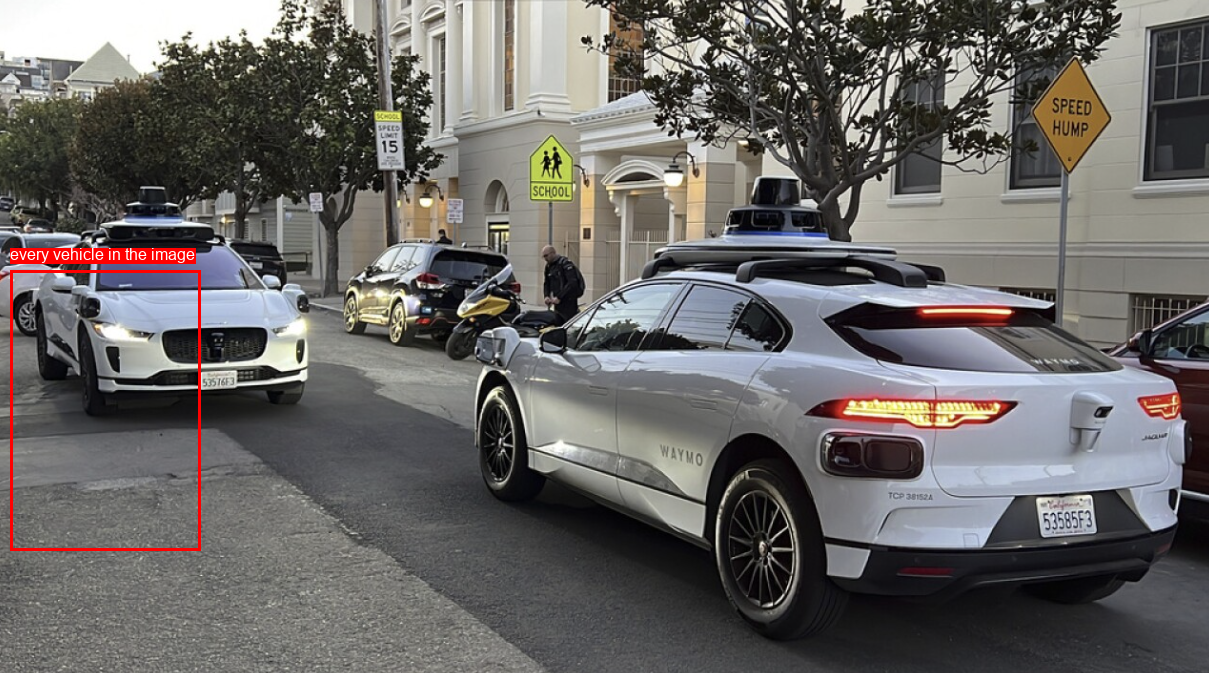

--------------------------------------------------


In [8]:
# Perform object grounding
if image_path:
    # Define referring expressions to try
    referring_expressions = [
        "every vehicle in the image",
        # "the person in the image",
        # "the red object",
        # "the largest object in the center",
        # "the object on the left side"
    ]
    
    print("🎯 Starting object grounding...")
    
    for i, expression in enumerate(referring_expressions, 1):
        print(f"\n--- Example {i}: '{expression}' ---")
        
        # Perform grounding
        result = grounder.ground_object(image_path, expression)
        
        # Print results
        print(f"✨ Model Response: {result['response']}")
        print(f"📍 Coordinates: {result['coordinates']}")
        print(f"✅ Success: {result['success']}")
        
        if result['success']:
            # Visualize the result
            vis_image = grounder.visualize_grounding(image_path, result)
            print(f"🖼️ Visualization for: '{expression}'")
            display(vis_image)
        else:
            print("❌ No coordinates found for this expression")
        
        print("-" * 50)
else:
    print("❌ No image available for grounding. Please set image_path manually.")


In [ ]:
def batch_ground_objects(grounder, image_path, expressions, save_all=False):
    """
    Perform grounding for multiple expressions on the same image
    
    Args:
        grounder: InternVL3OpenRouterGrounder instance
        image_path: Path to image or PIL Image
        expressions: List of referring expressions
        save_all: Whether to save all visualizations
    
    Returns:
        List of results
    """
    results = []
    
    print(f"🔄 Processing {len(expressions)} expressions...")
    
    for i, expression in enumerate(expressions, 1):
        print(f"\n📍 {i}/{len(expressions)}: '{expression}'")
        
        try:
            result = grounder.ground_object(image_path, expression)
            results.append(result)
            
            if result['success']:
                print(f"✅ Found coordinates: {result['coordinates']}")
                
                if save_all:
                    # Create visualization
                    vis_image = grounder.visualize_grounding(image_path, result, 
                                                           f"grounding_result_{i}.jpg")
            else:
                print("❌ No coordinates found")
                
        except Exception as e:
            print(f"❌ Error processing '{expression}': {e}")
            results.append({
                'response': str(e),
                'coordinates': None,
                'success': False,
                'referring_expression': expression
            })
    
    return results

def create_multi_object_visualization(grounder, image_path, results):
    """
    Create a single visualization showing all successful groundings
    
    Args:
        grounder: InternVL3OpenRouterGrounder instance  
        image_path: Path to image or PIL Image
        results: List of grounding results
    
    Returns:
        PIL Image with all bounding boxes
    """
    # Load original image
    if isinstance(image_path, str):
        image = Image.open(image_path).convert('RGB')
    else:
        image = image_path.convert('RGB')
    
    # Create visualization
    vis_image = image.copy()
    draw = ImageDraw.Draw(vis_image)
    
    # Track successful groundings
    successful_groundings = 0
    
    for i, result in enumerate(results):
        if result['success'] and result['coordinates']:
            x1, y1, x2, y2 = result['coordinates']
            
            # Use different colors for different objects
            color = colors[i % len(colors)]
            
            # Draw bounding box
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            
            # Add label
            text = f"{i+1}. {result['referring_expression']}"
            if len(text) > 40:
                text = text[:37] + "..."
            
            # Try to load font
            try:
                font = ImageFont.truetype("/System/Library/Fonts/Arial.ttf", 14)
            except:
                font = ImageFont.load_default()
            
            # Draw text with background
            text_bbox = draw.textbbox((x1, y1-20), text, font=font)
            draw.rectangle(text_bbox, fill=color)
            draw.text((x1, y1-20), text, fill='white', font=font)
            
            successful_groundings += 1
    
    # Add summary text
    summary = f"Successfully grounded {successful_groundings}/{len(results)} objects"
    draw.text((10, 10), summary, fill='black', font=ImageFont.load_default())
    
    return vis_image

print("✅ Batch processing utilities defined!")


In [ ]:
# Demonstrate batch processing
if image_path:
    # Define multiple expressions to ground
    batch_expressions = [
        "the main subject in the image",
        "the brightest area",
        "any text or writing",
        "the background",
        "the most colorful part"
    ]
    
    print("🚀 Starting batch grounding...")
    
    # Process all expressions
    batch_results = batch_ground_objects(grounder, image_path, batch_expressions)
    
    # Create multi-object visualization
    print("\n🎨 Creating combined visualization...")
    multi_vis = create_multi_object_visualization(grounder, image_path, batch_results)
    
    # Display the combined result
    print("🖼️ Combined visualization with all detected objects:")
    display(multi_vis)
    
    # Save the combined visualization
    multi_vis.save("multi_object_grounding.jpg")
    print("✅ Combined visualization saved as 'multi_object_grounding.jpg'")
    
    # Print summary statistics
    successful = sum(1 for r in batch_results if r['success'])
    print(f"\n📊 Grounding Summary:")
    print(f"   Total expressions: {len(batch_expressions)}")
    print(f"   Successful groundings: {successful}")
    print(f"   Success rate: {successful/len(batch_expressions)*100:.1f}%")
    
else:
    print("❌ No image available for batch processing.")


In [ ]:
# Tips and Best Practices for InternVL3 Grounding

tips = {
    "Referring Expression Quality": [
        "Be specific and descriptive",
        "Use clear visual attributes (color, size, position)",
        "Include spatial relationships ('left', 'center', 'behind')",
        "Avoid ambiguous terms"
    ],
    
    "Model Selection": [
        "InternVL3-14B: Good balance of performance and cost",
        "InternVL3-38B: Higher accuracy for complex scenes",
        "Test different models for your specific use case"
    ],
    
    "Image Quality": [
        "Use high-resolution images when possible",
        "Ensure good lighting and contrast",
        "Avoid heavily occluded objects",
        "Consider image orientation"
    ],
    
    "API Usage": [
        "Set temperature=0 for consistent results",
        "Handle API rate limits gracefully",
        "Cache results for repeated queries",
        "Monitor API costs"
    ],
    
    "Error Handling": [
        "Always check for successful coordinate parsing",
        "Implement retry logic for failed requests",
        "Validate bounding box coordinates",
        "Provide fallback visualizations"
    ]
}

print("🎯 InternVL3 Grounding Best Practices:")
print("=" * 50)

for category, practices in tips.items():
    print(f"\n📋 {category}:")
    for practice in practices:
        print(f"   • {practice}")

print("\n" + "=" * 50)
print("✨ Happy grounding! ✨")


In [ ]:
# Optional: Clean up temporary files
import os

# List of files that might have been created
temp_files = [
    "sample_image.jpg",
    "multi_object_grounding.jpg"
] + [f"grounding_result_{i}.jpg" for i in range(1, 11)]

# Ask user if they want to clean up
cleanup = input("🗑️ Remove temporary files? (y/n): ").lower().strip()

if cleanup == 'y':
    cleaned = 0
    for file in temp_files:
        if os.path.exists(file):
            try:
                os.remove(file)
                print(f"✅ Removed: {file}")
                cleaned += 1
            except Exception as e:
                print(f"❌ Could not remove {file}: {e}")
    
    if cleaned > 0:
        print(f"\n🧹 Cleaned up {cleaned} temporary files!")
    else:
        print("\n💭 No temporary files found to clean up.")
else:
    print("📁 Temporary files kept.")
